In [3]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [88]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

Print top 5 rows

In [3]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [48]:
def plot_timeseries(df):
    df.plot()

Plot the timeseries from above

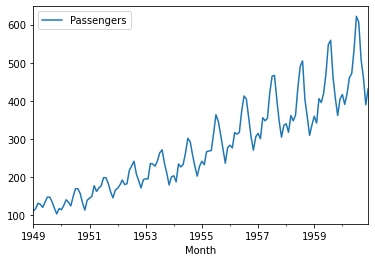

In [49]:
plot_timeseries(df)

Compute a rolling mean and a rolling std with an appropriate window size

In [50]:
rolling = df.rolling(30, center=True)

In [51]:
r_mean = rolling.mean()

In [52]:
r_std = rolling.std()

Plot two timeseries:
- with rolling mean 
- with rolling std

<AxesSubplot:xlabel='Month'>

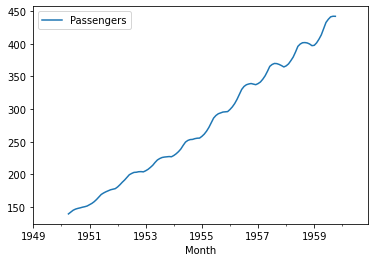

In [53]:
r_mean.plot()

<AxesSubplot:xlabel='Month'>

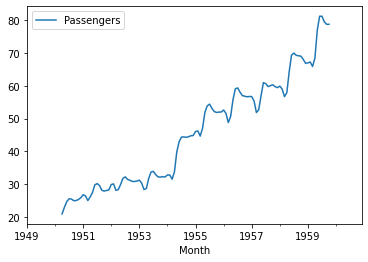

In [54]:
r_std.plot()

Test the stationarity of all timeseries

In [55]:
def ADF_Stationarity_Test(timeseries, significant_level):
    
    # print adfuller test results
    
    result = adfuller(timeseries)
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # print conclusion (stationary or not) based on sig level
    if result[1] > significant_level:
        print('Timeseries is non-stationary')
    else:
        print('Timeseries is stationary')
    

In [56]:
r_mean = r_mean.dropna()

In [57]:
r_std = r_std.dropna()

In [58]:
ADF_Stationarity_Test(df, 0.05)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Timeseries is non-stationary


In [59]:
ADF_Stationarity_Test(r_mean, 0.05)

ADF Statistic: 1.326270
p-value: 0.996752
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582
Timeseries is non-stationary


In [60]:
ADF_Stationarity_Test(r_std, 0.05)

ADF Statistic: 0.479894
p-value: 0.984249
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582
Timeseries is non-stationary


Transform the original timeseries with logarithm

In [143]:
df_log = np.log(df)

Plot transformed timeseries

In [179]:
df_log

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


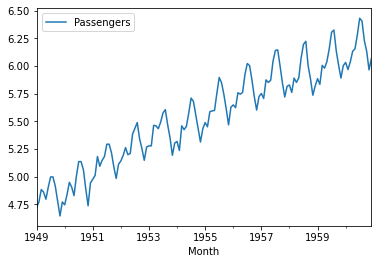

In [62]:
plot_timeseries(df_log)

Test the stationarity of transformed timeseries. If it isn't stationary, try different transformation techniques

In [63]:
ADF_Stationarity_Test(df_log, 0.05)

ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Timeseries is non-stationary


In [95]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

In [32]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [115]:
df_log.isnull().sum()

Passengers    0
dtype: int64

In [144]:
diff = difference(df_log['Passengers'])

In [121]:
diff.fillna(method='bfill', inplace=True)

In [67]:
df_transformed = df_transformed.dropna()

In [140]:
ADF_Stationarity_Test(diff, 0.05)

ADF Statistic: -8.196629
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579
Timeseries is stationary


Use the stationary TS and find the optimal (p,d,q) params of ARIMA model

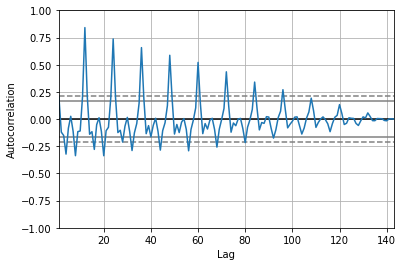

In [145]:
pd.plotting.autocorrelation_plot(diff)
plt.show()

Plot the predictions (not transformed to the original scale)

In [24]:
from pmdarima import auto_arima

In [147]:
stepwise_model = auto_arima(df_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=1.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=0.57 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.26 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=1.11 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.955, Time=1.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=0.45 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.902, Time=2.86 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=0.81 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=0.55 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=2.06 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-481.400, Time=0.61 sec

Best model:  ARIMA

In [69]:
from statsmodels.tsa.arima_model import ARIMA

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Tue, 10 Nov 2020   AIC                           -237.507
Time:                        14:11:28   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0097      0.011      0.887      0.375      -0.012       0.031
ma.L1.D.Passengers     0.2722      0.095      2.873      0.004       0.086       0.458
                    

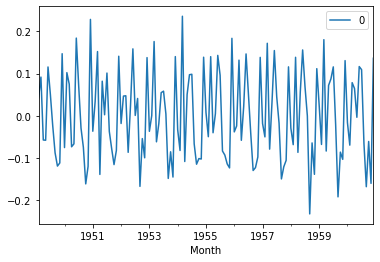

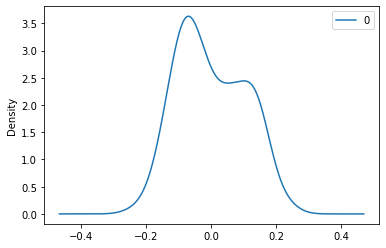

                0
count  143.000000
mean    -0.000016
std      0.103616
min     -0.232769
25%     -0.083033
50%     -0.018430
75%      0.089531
max      0.235844


In [176]:
model = ARIMA(df_log['Passengers'], order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Plot the predictions (transformed to the original scale)

In [30]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

predicted=5.586149, expected=5.723585
predicted=5.766760, expected=5.752573
predicted=5.760151, expected=5.707110
predicted=5.704678, expected=5.874931
predicted=5.925698, expected=5.852202
predicted=5.848943, expected=5.872118
predicted=5.888413, expected=6.045005
predicted=6.092095, expected=6.142037
predicted=6.167054, expected=6.146329
predicted=6.155518, expected=6.001415
predicted=5.977990, expected=5.849325
predicted=5.827872, expected=5.720312
predicted=5.700990, expected=5.817111
predicted=5.857075, expected=5.828946
predicted=5.832314, expected=5.762051
predicted=5.753583, expected=5.891644
predicted=5.936553, expected=5.852202
predicted=5.843429, expected=5.894403
predicted=5.916215, expected=6.075346
predicted=6.125396, expected=6.196444
predicted=6.226988, expected=6.224558
predicted=6.237070, expected=6.001415
predicted=5.952153, expected=5.883322
predicted=5.875587, expected=5.736572
predicted=5.707015, expected=5.820083
predicted=5.858009, expected=5.886104
predicted=5.

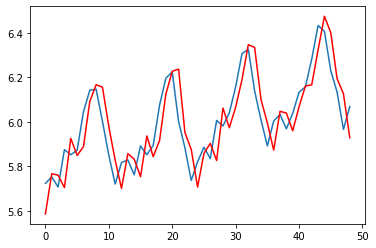

In [193]:
X = df_log['Passengers'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Plot the predictions for the next 10 years

In [194]:
forecast = model_fit.forecast(steps=120)[0]

In [182]:
forecast

array([5.95056396, 5.99633908, 6.08594821, 6.19359308, 6.29119286,
       6.35611966, 6.37671352, 6.35432055, 6.30165172, 6.23826353,
       6.18465306, 6.15668301, 6.16179557, 6.19785139, 6.25464565,
       6.317432  , 6.37131409, 6.40524457, 6.41460069, 6.40178787,
       6.37490395, 6.34501259, 6.32289194, 6.31618002, 6.32764116,
       6.35490671, 6.39161426, 6.42950274, 6.46080904, 6.48029528,
       6.48640099, 6.48129826, 6.46994304, 6.45847541, 6.45246065,
       6.45545736, 6.46826334, 6.48897416, 6.51375875, 6.53807383,
       6.55794927, 6.57099347, 6.57687755, 6.57722008, 6.57496238,
       6.57345147, 6.57550493, 6.58270944, 6.59511764, 6.61138519,
       6.62926796, 6.64631085, 6.66052527, 6.67087501, 6.67745963,
       6.68137591, 6.68432626, 6.68810375, 6.69410359, 6.70298912,
       6.71458656, 6.72801387, 6.7419865 , 6.75520058, 6.76668356,
       6.77602171, 6.78341573, 6.78956652, 6.79543845, 6.80197551,
       6.80985075, 6.81931304, 6.83016224, 6.84184699, 6.85364

In [184]:
forecast_transformed

array([11.98843488, 12.03421   , 12.12381913, 12.231464  , 12.32906378,
       12.39399058, 12.41458444, 12.39219147, 12.33952264, 12.27613445,
       12.22252398, 12.19455393, 12.19966649, 12.23572231, 12.29251657,
       12.35530292, 12.40918501, 12.44311549, 12.45247161, 12.43965879,
       12.41277487, 12.38288351, 12.36076286, 12.35405094, 12.36551208,
       12.39277763, 12.42948518, 12.46737366, 12.49867996, 12.5181662 ,
       12.52427191, 12.51916918, 12.50781396, 12.49634633, 12.49033157,
       12.49332828, 12.50613426, 12.52684508, 12.55162967, 12.57594475,
       12.59582019, 12.60886439, 12.61474847, 12.615091  , 12.6128333 ,
       12.61132239, 12.61337585, 12.62058036, 12.63298856, 12.64925611,
       12.66713888, 12.68418177, 12.69839619, 12.70874593, 12.71533055,
       12.71924683, 12.72219718, 12.72597467, 12.73197451, 12.74086004,
       12.75245748, 12.76588479, 12.77985742, 12.7930715 , 12.80455448,
       12.81389263, 12.82128665, 12.82743744, 12.83330937, 12.83

In [195]:
forecast_transformed = np.exp(forecast)

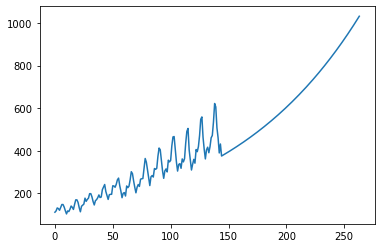

In [197]:
plt.plot(np.concatenate([df['Passengers'].values, forecast_transformed]))
plt.show()